In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import clear_output

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bundesliga-results-19932018/Bundesliga_Results.csv


Loading the full dataset

In [2]:
full_dataset = pd.read_csv("/kaggle/input/bundesliga-results-19932018/Bundesliga_Results.csv")
full_dataset.tail()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
7645,D1,12/5/2018,Hoffenheim,Dortmund,3,1,H,1.0,0.0,H,2017-18
7646,D1,12/5/2018,Leverkusen,Hannover,3,2,H,2.0,0.0,H,2017-18
7647,D1,12/5/2018,Mainz,Werder Bremen,1,2,A,1.0,1.0,D,2017-18
7648,D1,12/5/2018,Schalke 04,Ein Frankfurt,1,0,H,1.0,0.0,H,2017-18
7649,D1,12/5/2018,Wolfsburg,FC Koln,4,1,H,1.0,1.0,D,2017-18


Converting "Date" col to datetime

In [3]:
full_dataset['ConvertedDate'] = pd.to_datetime(full_dataset["Date"], infer_datetime_format=True)
full_dataset.tail()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season,ConvertedDate
7645,D1,12/5/2018,Hoffenheim,Dortmund,3,1,H,1.0,0.0,H,2017-18,2018-12-05
7646,D1,12/5/2018,Leverkusen,Hannover,3,2,H,2.0,0.0,H,2017-18,2018-12-05
7647,D1,12/5/2018,Mainz,Werder Bremen,1,2,A,1.0,1.0,D,2017-18,2018-12-05
7648,D1,12/5/2018,Schalke 04,Ein Frankfurt,1,0,H,1.0,0.0,H,2017-18,2018-12-05
7649,D1,12/5/2018,Wolfsburg,FC Koln,4,1,H,1.0,1.0,D,2017-18,2018-12-05


Creating a functions to build the dataset to feed our model.

In [4]:
def get_game_result(game):
    if game['TeamScore'] > game['OppScore']:
        return 'W'
    elif game['TeamScore'] < game['OppScore']:
        return 'L'
    else:
        return 'D'

def get_team_previous_games(games, team, game_date, season):
    home_previous_games = games.loc[(games['HomeTeam'] == team) & (games['Season'] == season) & (games['ConvertedDate'] < game_date)]
    away_previous_games = games.loc[(games['AwayTeam'] == team) & (games['Season'] == season) & (games['ConvertedDate'] < game_date)]
    
    home_previous_games.rename(columns = {'HomeTeam': 'TeamName', 'FTHG': 'TeamScore',
                                          'AwayTeam': 'OppName', 'FTAG': 'OppScore'}, inplace=True)
    
    away_previous_games.rename(columns = {'AwayTeam': 'TeamName', 'FTAG': 'TeamScore',
                                          'HomeTeam': 'OppName', 'FTHG': 'OppScore'}, inplace=True)
    
    previous_games = pd.concat([home_previous_games, away_previous_games], axis=0, ignore_index=True)
    previous_games.sort_values('ConvertedDate', inplace=True)
    
    if len(previous_games) < 5:
        return {'error': True}
    
    previous_games['Result'] = previous_games.apply(lambda x: get_game_result(x), axis=1)
    
    return {'error': False, 'data': previous_games}

def get_team_stats(games, team, game_date, season):
    previous_games = get_team_previous_games(games, team, game_date, season)
    
    if previous_games['error']:
        return None
    
    previous_games = previous_games['data']
    last_5 = previous_games.tail(5)
    
    draw_pct = (len(previous_games[previous_games['Result'] == 'D'])*100)/len(previous_games)
    win_pct = (len(previous_games[previous_games['Result'] == 'W'])*100)/len(previous_games)
    loss_pct = (len(previous_games[previous_games['Result'] == 'L'])*100)/len(previous_games)
    
    return team, last_5.TeamScore.mean(), last_5.OppScore.mean(), draw_pct, win_pct, loss_pct

Now let's build the dataframe with data that we are going to be using in our models.

In [5]:
data_list = []

for idx, row in full_dataset.iterrows():
    clear_output()
    print(f"Building dataset {idx}/{len(full_dataset)}")
    
    home_stats = get_team_stats(full_dataset, row['HomeTeam'], row['ConvertedDate'], row['Season'])
    away_stats = get_team_stats(full_dataset, row['AwayTeam'], row['ConvertedDate'], row['Season'])
    
    if not home_stats or not away_stats:
        continue
        
    game_data = list(home_stats + away_stats)
    game_data.append(row['FTR'])
        
    data_list.append(game_data)

Building dataset 7649/7650


In [6]:
columns = ['HomeTeam', 'HomeScoreMean', 'HomeScoreConcededMean', 'HomeDrawPct', 'HomeWinPct', 'HomeLossPct',
           'AwayTeam', 'AwayScoreMean', 'AwayScoreConcededMean', 'AwayDrawPct', 'AwayWinPct', 'AwayLossPct',
           'Result']
data_df = pd.DataFrame(data_list, columns=columns)
display(data_df)

,HomeTeam,HomeScoreMean,HomeScoreConcededMean,HomeDrawPct,HomeWinPct,HomeLossPct,AwayTeam,AwayScoreMean,AwayScoreConcededMean,AwayDrawPct,AwayWinPct,AwayLossPct,Result
0,Bayern Munich,2.0,1.0,40.000000,40.000000,20.000000,Freiburg,1.8,2.4,40.000000,20.000000,40.000000,H
1,Dortmund,1.8,1.2,40.000000,40.000000,20.000000,Karlsruhe,2.2,1.6,60.000000,20.000000,20.000000,H
2,Duisburg,1.6,1.8,60.000000,20.000000,20.000000,Leverkusen,1.8,1.0,40.000000,40.000000,20.000000,D
3,FC Koln,1.0,0.6,20.000000,40.000000,40.000000,Kaiserslautern,2.0,1.8,20.000000,40.000000,40.000000,A
4,Hamburg,1.2,1.8,60.000000,20.000000,20.000000,Nurnberg,0.8,1.6,0.000000,40.000000,60.000000,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6467,Hoffenheim,2.2,1.2,30.303030,42.424242,27.272727,Dortmund,2.0,1.0,30.303030,45.454545,24.242424,H
6468,Leverkusen,1.4,1.2,30.303030,42.424242,27.272727,Hannover,1.8,1.8,27.272727,30.303030,42.424242,H
6469,Mainz,1.6,1.4,27.272727,27.272727,45.454545,Werder Bremen,1.6,1.0,36.363636,27.272727,36.363636,A
6470,Schalke 04,1.4,1.4,27.272727,51.515152,21.212121,Ein Frankfurt,2.2,2.0,21.212121,42.424242,36.363636,H


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_df.drop('Result', axis=1), data_df['Result'])

# Defining categorical columns
categorial_cols = [X_train.dtypes.index[i] for i in range(len(X_train.dtypes)) if X_train.dtypes[i] == 'object']

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Bundle preprocessing for categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorial_cols)
    ])

# Defining model
model = GradientBoostingClassifier(random_state=0)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, preds)
print('Accuracy:', accuracy)

Accuracy: 0.48393077873918416


In [8]:
pred_series = pd.Series(preds)
res_value_counts = pred_series.value_counts()
res_value_counts

H    1320
A     203
D      95
dtype: int64

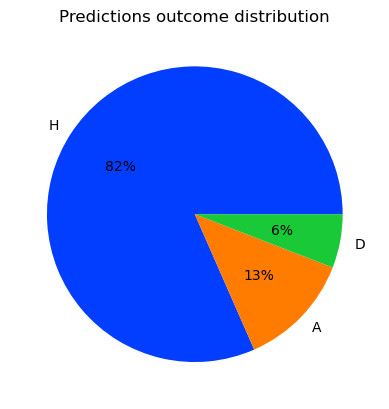

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# define Seaborn color palette to use
palette_color = sns.color_palette('bright')
  
# plotting data on chart
plt.pie(res_value_counts, labels=res_value_counts.index, colors=palette_color, autopct='%.0f%%')
plt.title("Predictions outcome distribution")
  
# displaying chart
plt.show()